# Chi-Squared Test

Here, we generate samples of the chi-squared test statistic using i.i.d standard normal variates.


In [1]:
%matplotlib inline
%load_ext cython

# Import requisite modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


In [2]:
# Run parameters
seed = 22
numVariates = 20 # Number of i.i.d normal variates per repetition for the Chi-squared test
numRepetitions = 10000 # Number of repetitions of bin counts for the Chi-squared test
quantiles = [0.0, 0.25, 0.5, 0.75, 1.0] # Quantiles for binning the simulated data

In [3]:
# Simulations
np.random.seed(seed) # Make simulation repeatable with seed parameter
data = np.random.normal(size=(numRepetitions, numVariates)) # Generate numRepetitions x numVariates i.i.d standard normals


In [4]:
# Intermediate quantities
bins = [norm.ppf(b) for b in quantiles]


In [5]:
#%%cython -a
#import numpy as np

def ComputeChiSquaredStatisics(data, bins):
    numRepetitions = np.shape(data)[0]
    numVariates = np.shape(data)[1]
    
    means = np.mean(data, axis=1)
    stdvs = np.std(data, axis=1)
    
    expected = np.diff(np.array([norm.cdf(b, loc=means, scale=stdvs) for b in bins]), axis=0).T
    observed = np.array([np.histogram(data[i], bins=bins)[0] for i in range(numRepetitions)])
    output = np.sum((observed - expected) ** 2 / expected, axis=1)
    
    return output
        
            


In [6]:
x = ComputeChiSquaredStatisics(data, bins)


(array([  1.30900000e+03,   1.57300000e+03,   1.40000000e+03,
          1.08500000e+03,   9.02000000e+02,   7.59000000e+02,
          5.46000000e+02,   4.70000000e+02,   3.75000000e+02,
          3.15000000e+02,   2.33000000e+02,   2.45000000e+02,
          1.66000000e+02,   1.33000000e+02,   1.02000000e+02,
          6.50000000e+01,   6.10000000e+01,   5.30000000e+01,
          4.40000000e+01,   3.50000000e+01,   2.50000000e+01,
          2.10000000e+01,   1.80000000e+01,   1.00000000e+01,
          9.00000000e+00,   7.00000000e+00,   8.00000000e+00,
          5.00000000e+00,   3.00000000e+00,   2.00000000e+00,
          5.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   3.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   3.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

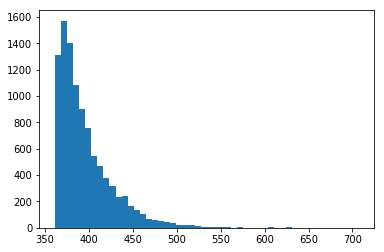

In [8]:
plt.hist(x, bins=50)